In [1]:
import os
import numpy as np
from numpy.random import multivariate_normal
from sklearn.preprocessing import normalize

from scipy.io import loadmat
import matplotlib.pyplot as plt
plt.rcParams['font.size'] =14
%cd "/content/drive/Othercomputers/MacBook-Air/CSE 847 Machine Learninng/MSU-CSE-847-Homeworks/HW-05"
os.makedirs("plots", exist_ok=True)

/content/drive/Othercomputers/MacBook-Air/CSE 847 Machine Learninng/MSU-CSE-847-Homeworks/HW-05


## K-means Clustering

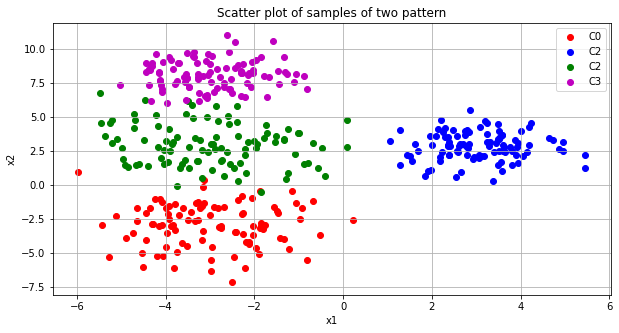

In [4]:
# Setting parameters
mu1 = np.array([[-3,-3]]).T
mu2 = np.array([[3,3]]).T
sigma1 = np.eye(2)*2
sigma2 = np.eye(2)

mu3 = np.array([[-3,3]]).T
mu4 = np.array([[-3,8]]).T
sigma3 = np.eye(2)*2
sigma4 = np.eye(2)
no_samples = 100

# Generating the patterns
pattern1, pattern2, pattern3, pattern4 = [], [], [], []
for i in range(no_samples):
    pattern1.append(multivariate_normal(mu1.squeeze(), sigma1))
    pattern2.append(multivariate_normal(mu2.squeeze(), sigma2))
    pattern3.append(multivariate_normal(mu3.squeeze(), sigma3))
    pattern4.append(multivariate_normal(mu4.squeeze(), sigma4))
pattern1 = np.array(pattern1)
pattern2 = np.array(pattern2)
pattern3 = np.array(pattern3)
pattern4 = np.array(pattern4)


# Plotting 1c
plt.figure(figsize=(10,5))
fig = plt.gcf()
plt.scatter(pattern1[:, 0], pattern1[:, 1], c= 'r', label="C0")
plt.scatter(pattern2[:, 0], pattern2[:, 1], c = 'b', label="C2")
plt.scatter(pattern3[:, 0], pattern3[:, 1], c= 'g', label="C2")
plt.scatter(pattern4[:, 0], pattern4[:, 1], c = 'm', label="C3")
plt.grid()
plt.title("Scatter plot of samples of two pattern")
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.savefig('plots/cluster-dataset.png', dpi=200)

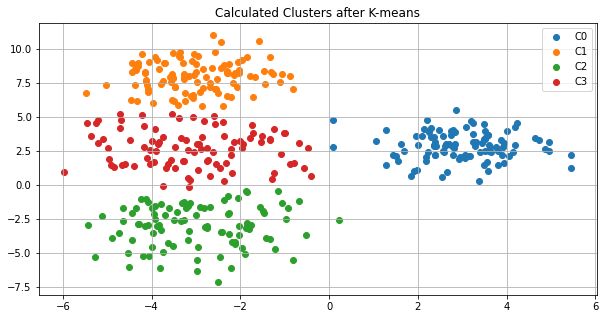

In [5]:
data = np.concatenate((pattern1, pattern2, pattern3, pattern4), axis=0)


def my_kmeans(data, K, maxIter=1000):
    # Parameter Setup
    # K = 4
    maxIter  = 1000


    (n,d) = data.shape
    C = data[np.random.randint(low=0, high=n, size=K)]

    # Creating the cluster membership matrix
    m = np.zeros((n,K), dtype=np.int8)


    for iter in range(maxIter):
        # Updating m
        for i in range(n):
                dists = np.sum((data[i] - C)**2, axis=1)
                m[i, :] =0
                m[i, np.argmin(dists)] = 1

        # Updating C
        for j in range(K):
            C[j] = np.mean(data[np.where(m[:,j]==1)], axis=0)

    return m



def plot_clusters(data, m, title = None, figname = None):
    """
    data = N*d dimensional dataset where each row is a sample
    m = cluster membership matrix
    """
    K = m.shape[1]

    # Plotting The Clusters
    plt.figure(figsize=(10,5))
    for j in range(K):
        cluster =  data[np.where(m[:,j]==1)]
        plt.scatter(cluster[:, 0], cluster[:, 1], label=f"C{j}")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig(f"plots/{figname}", dpi=200)



m = my_kmeans(data, K=4, maxIter=200)
plot_clusters(data, m, 
              title= "Calculated Clusters after K-means",
              figname="regular-cluster-k-means.png")

## K-mean Clustering with Spectral Relaxation

In [6]:
data_file = "data_Aggregation.mat"

data = loadmat(data_file)["D"]
labels = loadmat(data_file)["L"]

# Creating Label Matrix
labels_matrix = np.zeros((len(labels), labels.max()))
for i, lbl in enumerate(labels):
    labels_matrix[i, lbl-1] = 1

In [7]:
def transform_spectral(data, K):
    # Setting the dimestions
    N, d = data.shape

    # Calculating the affinity matrix
    A = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            A[i,j] = np.linalg.norm(data[i] - data[j])


    # Calculating the Laplacian
    D = np.diag(A.sum(axis=1))
    L = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            L[i,j] = A[i,j] / (np.sqrt(D[i,i] * D[j,j]))

    # Eigen Decomposition
    eig_values, eig_vectors = np.linalg.eig(L)

    # Renormalization

    matrix_X = eig_vectors[:, :K]
    print(eig_vectors.shape, matrix_X.shape)
    matrix_Y = normalize(matrix_X, axis=0)

    return matrix_Y



(788, 788) (788, 5)


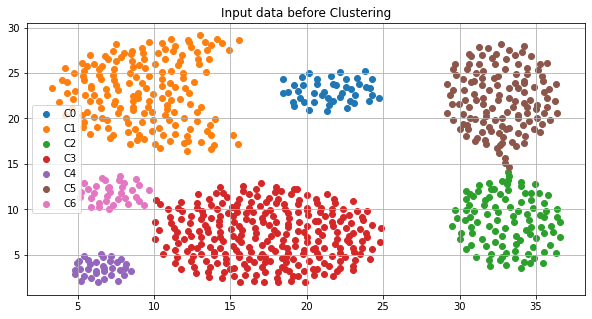

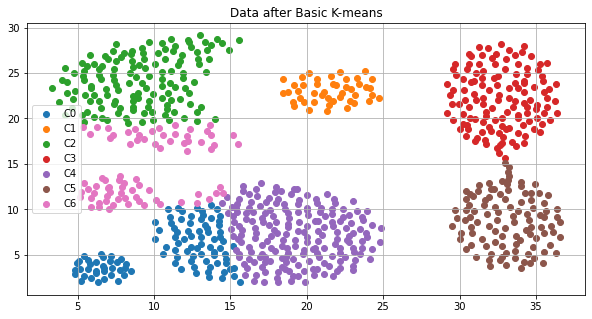

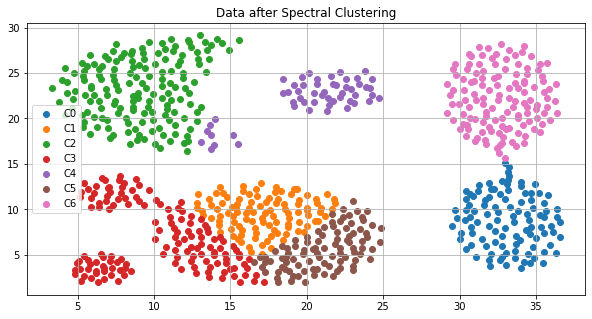

In [11]:
matrix_Y = transform_spectral(data, K=5)
spectral_cluster_labels = my_kmeans(matrix_Y, K=labels.max(), maxIter= 1000)
basic_kmeans_cluster_labels = my_kmeans(data, K=labels.max(), maxIter=1000)



# Plotting data with labels
plot_clusters(loadmat(data_file)["D"], labels_matrix, 
              title="Input data before Clustering",
              figname="Spectral_data_input.png")


# Plotting K-means data without spectral relaxation
plot_clusters(loadmat(data_file)["D"], basic_kmeans_cluster_labels, 
              title="Data after Basic K-means",
              figname="Kmeans(without_spectral_relaxation).png")


# Plotting K-means data with spectral relaxation
plot_clusters(loadmat(data_file)["D"], spectral_cluster_labels, 
              title="Data after Spectral Clustering",
              figname="Kmeans(with_spectral_relaxation).png")